In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Stellar rotation with Gaussian Processes

This tutorial will introduce the basic features of Gaussian Process (GP) regression via ``periodicity`` by studying the ``SpottedStar`` photometric data from Kepler.
The module ``periodicity.gp`` includes a few predefined classes using different GP kernels; their difference is better explained in the User Guide, but they all have one thing in common: a "period" hyperparameter.
One can also define their very own ``periodicity`` compatible GP modeler, using either ``george`` or ``celerite2`` to define their kernel, but here we will stick with the prepackaged ``HarmonicGP`` class.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from periodicity.core import TSeries
from periodicity.data import SpottedStar
from periodicity.gp import HarmonicGP, make_gaussian_prior, make_ppf

The ``HarmonicGP`` is built upon the ``celerite2.terms.RotationTerm``, which is the sum of two Stochastically-driven Harmonic Oscillator (SHO) terms; the secondary term"s period is half the primary one"s, and their relative contributions are controlled by a mixing ratio hyperparameter. More details can be found at ``celerite2`` [excellent documentation.](https://celerite2.readthedocs.io/en/latest/)

More importantly, this kernel presents both positive and negative covariance values, which can be useful for some processes (this being one of them).

In [3]:
plt.rc("lines", linewidth=1.0, linestyle="-", color="black")
plt.rc("font", family="sans-serif", weight="normal", size=12.0)
plt.rc("text", color="black", usetex=True)
plt.rc("text.latex", preamble="\\usepackage{cmbright}")
plt.rc(
    "axes",
    edgecolor="black",
    facecolor="white",
    linewidth=1.0,
    grid=False,
    titlesize="x-large",
    labelsize="x-large",
    labelweight="normal",
    labelcolor="black",
)
plt.rc("axes.formatter", limits=(-4, 4))
plt.rc(("xtick", "ytick"), labelsize="x-large", direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc(("xtick.major", "ytick.major"), size=7, pad=6, width=1.0)
plt.rc(("xtick.minor", "ytick.minor"), size=4, pad=6, width=1.0, visible=True)
plt.rc("legend", numpoints=1, fontsize="x-large", shadow=False, frameon=False)

The creation of a GP object is pretty straightforward. Once you have a TSeries representing your data, the model can be initialized with the corresponding uncertainties as such:

In [4]:
time, flux, flux_err = SpottedStar()
signal = TSeries(time, flux)
model = HarmonicGP(signal, flux_err)

The data are taken from Kepler observations of the star KIC 9655172 from December 2009 to June 2010 (totalling six months or ~180 days). If we plot the data, we can visually detect a seasonality of ~10 days, which is clearly not strictly periodic. We also note the tiny size of the error bars, indicating a very high signal-to-noise ratio.

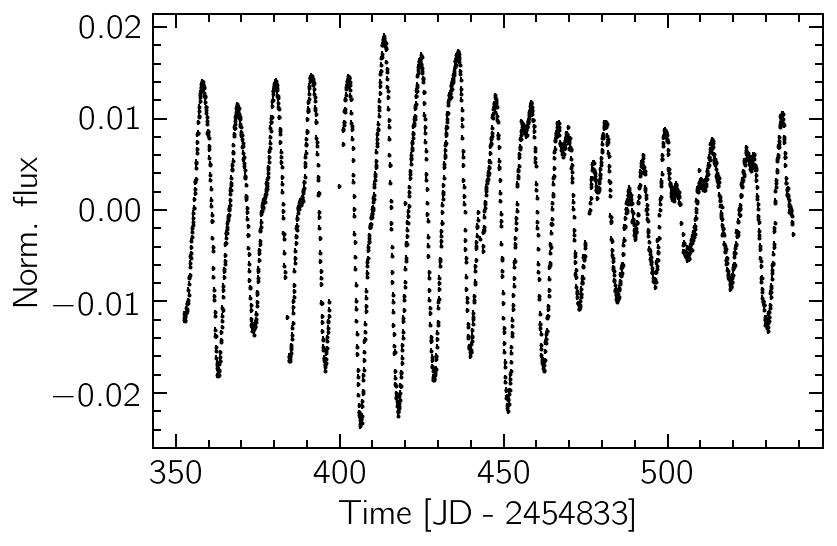

In [5]:
plt.errorbar(time, flux, flux_err, fmt="k.", ms=2)
plt.xlabel("Time [JD - 2454833]")
plt.ylabel("Norm. flux");

## Maximum Likelihood Hyperparameters

The model hyperparameters can be optimized to maximize the likelihood of the data. This is performed on the unit hypercube, and can be converted to real units using the ``prior_transform`` method.

In [6]:
soln, opt_gp = model.minimize(model.gp)
print(model.prior_transform(soln.x))

{'mean': -0.00016600149835243423, 'sigma': 0.00886947801744532, 'period': 11.025243233068581, 'Q0': 5.056973979108306, 'dQ': 42.38472792648548, 'f': 0.1432079772222711, 'jitter': 8.745275247612219e-08}


The resulting optimal kernel can then be used to make predictions on different time values. This is not only used to interpolate missing observations, but can also extrapolate to unobserved past of future times. The uncertainties here are essential to interpret the resulting predictions.

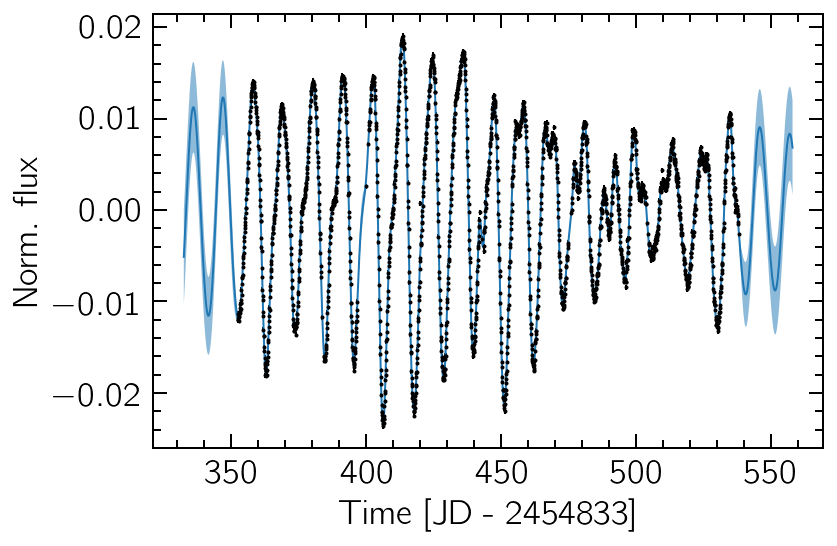

In [7]:
tpred = np.linspace(model.t[0] - 20, model.t[-1] + 20, 1000)
ypred, sd = model.get_prediction(tpred, opt_gp)

plt.plot(tpred, ypred)
plt.errorbar(time, flux, flux_err, fmt="k.", ms=2)
plt.fill_between(tpred, ypred - sd, ypred + sd, alpha=0.5)
plt.xlabel("Time [JD - 2454833]")
plt.ylabel("Norm. flux");

## Gaussian Mixture as a Prior Probability Distribution

In order to better estimate the hyperparameter values, a Bayesian inference is usually recommended. Since we are mostly concerned with the period of the process, this is the only hyperparameter we will try and make as informative as possible.

One option is creating a Gaussian Mixture distribution, where each Gaussian component is determined by the autocorrelation of different band-pass-filtered versions of the original data. This is based on the idea of [Angus et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.474.2094A).

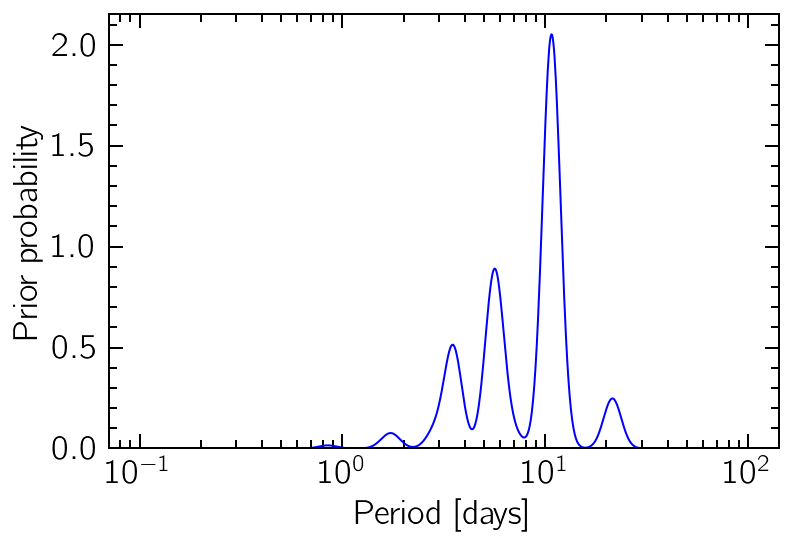

In [8]:
prior = make_gaussian_prior(signal)

periods = np.logspace(-1, 2, 1000)
prior_probs = prior(np.log(periods))
plt.plot(periods, prior_probs, "b")
plt.xlabel("Period [days]")
plt.ylabel("Prior probability")
plt.ylim(0)
plt.xscale("log");

The way these GP objects work, instead of a mapping from period-space into probability-space we will need to specify a reverse transformation, from the probability-space (unit line) into the corresponding quantiles of the distribution. This can be very hard to do analytically, depending on the exact distribution, so we use ``make_ppf`` to create a numeric interpolation that inverts the cumulative distribution of the PDF we just defined.  

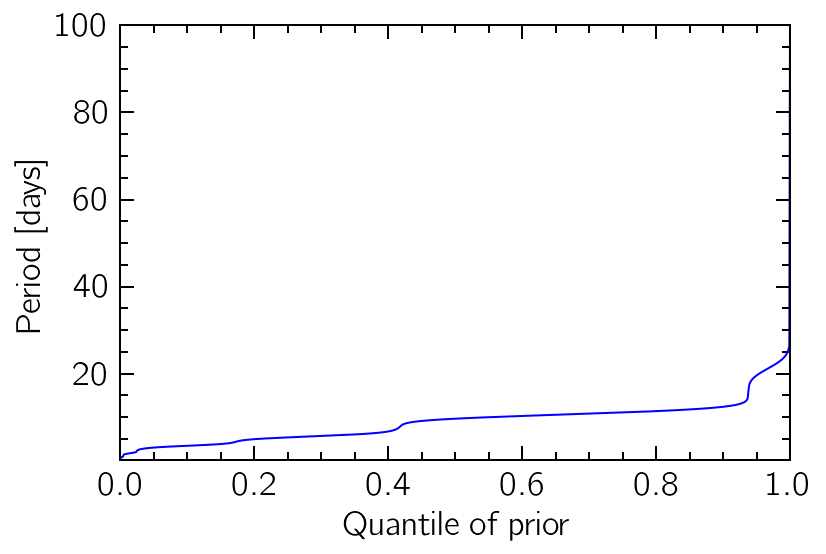

In [9]:
prior_ppf = make_ppf(periods, prior_probs)
model.period_prior = prior_ppf

quantiles = np.linspace(0, 1, 1000)
plt.plot(quantiles, prior_ppf(quantiles), "b")
plt.xlim(0, 1)
plt.ylim(0.1, 100)
plt.xlabel("Quantile of prior")
plt.ylabel("Period [days]");

## Sampling the Posterior Probability Density

Now that our prior is defined, running a Markov Chain Monte Carlo (MCMC) simulation is everything we need to get a feel for the posterior distribution of the hyperparameters.

In [10]:
samples, tau = model.mcmc(n_walkers=32, n_steps=5000, burn=500, random_seed=42)

100%|██████████| 5000/5000 [06:34<00:00, 12.67it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 90;
tau: [ 99.72551401 154.98042982 103.92194232 147.91348714 186.18706053
 215.56281431  89.18027946]


You will notice the warning message telling us the chain is too short to accurately estimate the integrated autocorrelation time; since we are keeping things relatively simple and won"t run any convergence diagnostics, we can safely ignore this (for now).

The samples we obtain are a dictionary, with a label for each hyperparameter. This can be useful for further analysis using a library like pandas, for example.

Our MAP period estimate can be taken from the median of the posterior distribution, and we can also estimate a confidence interval from the 16th and 84th percentiles:

In [11]:
print("Median period:", np.median(samples["period"]))
print("16th percentile:", np.percentile(samples["period"], 16))
print("84th percentile:", np.percentile(samples["period"], 84))

Median period: 11.02531261135498
16th percentile: 10.916270459499716
84th percentile: 11.130755005207826


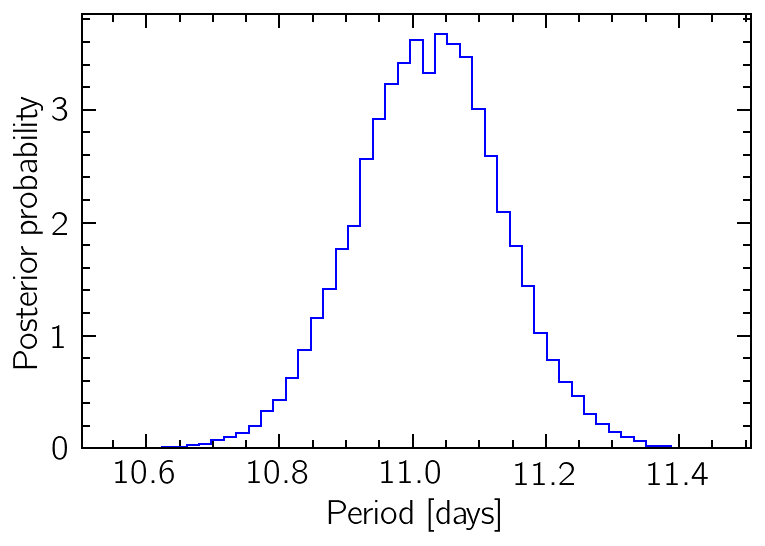

In [12]:
bins = np.linspace(np.min(samples["period"]), np.max(samples["period"]), 50)
plt.hist(samples["period"], bins=bins, histtype="step", color="b", density=True)
plt.xlabel("Period [days]")
plt.ylabel("Posterior probability");